# Kaggle 2018 Data Science Bowl  

Find the nuclei in divergent images to advance medical discovery  

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt

root_path = Path('/media/share/data/kaggle/2018-dsb')

## Naive computer vision method
First try naive cv method to setup a baseline 

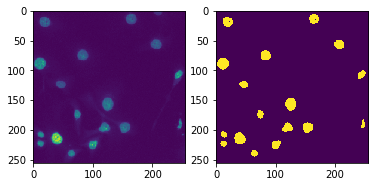

In [2]:
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.morphology import remove_small_objects

trainfile = os.listdir(root_path / 'stage1_train')

idx = random.choice(trainfile)
fname = idx + '.png'
img = io.imread(root_path / 'stage1_train' / idx / 'images' / fname)

img_gray = rgb2gray(img)
thre = threshold_otsu(img_gray)
img_f1 = remove_small_objects(img_gray > thre, 64)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img_gray)
ax2.imshow(img_f1)

## Testing

In [3]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [4]:
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.morphology import remove_small_objects
from scipy import ndimage
    
testfile = os.listdir(root_path / 'stage1_test')

def img_proc(indexlist):
    
    imgn = indexlist + '.png'
    img = io.imread(root_path / 'stage1_test' / indexlist / 'images' / imgn)

    img_gray = rgb2gray(img)
    thre = threshold_otsu(img_gray)
    img_f = remove_small_objects(img_gray > thre, 16)
    
    im_df = pd.DataFrame([])
    
    # label image regions
    labels, nlabels = ndimage.label(img_f)

    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': indexlist, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df

In [5]:
from multiprocessing import Pool, cpu_count

with Pool(cpu_count()) as pool:
    img = pool.map(img_proc, testfile)
    
    
subm_df = pd.DataFrame([])

for i in img:
    subm_df = pd.concat([subm_df, i], 0)
    
    
subm_df.reset_index(drop=True, inplace=True)

In [ ]:
submition = pd.concat([subm_df['ImageId'], subm_df['EncodedPixels']], 1)
submition.to_csv('/media/share/jiaxin_cmu/kaggle/DSB2018/subm04.csv', index=False)

## Results
LB: 0.241